In [1]:
import sys
from itertools import repeat
import data, data.gene_datasets
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model, sklearn.neural_network, sklearn.tree
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import gene_inference, gene_inference.utils
from gene_inference.models import lr, mlp, decision_tree
from gene_inference.infer_genes import infer_gene, infer_all_genes, sample_neighbors


/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tcgatissue = data.gene_datasets.TCGATissue(data_dir='./genomics/TCGA/')

Converting one-hot labels to integers


In [3]:
class Object(object):
    pass
opt = Object()
opt.seed = 0
opt.nb_class = None
opt.nb_examples = None
opt.nb_nodes = None
opt.graph = "pathway"
opt.dataset = tcgatissue

In [4]:
tcgatissue.set_graph(opt)

'Graph' object has no attribute 'labels'


In [5]:
g = nx.from_numpy_matrix(tcgatissue.adj)
mapping = dict(zip(range(0, len(tcgatissue.df.columns)), tcgatissue.df.columns))
g = nx.relabel_nodes(g, mapping)

In [ ]:
# Take a subset of tcga
df = tcgatissue.df.iloc[0:1000, 0:10] 

lr_df = infer_all_genes(lr, df, g.subgraph(df.columns)).reset_index(drop=True)
mlp_df = infer_all_genes(mlp, df, g.subgraph(df.columns)).reset_index(drop=True)
dt_df = infer_all_genes(decision_tree, df, g.subgraph(df.columns)).reset_index(drop=True)

Genes to do:10
Trial number:> /Users/martinweiss/code/conv-graph/gene_inference/infer_genes.py(18)infer_gene()
-> temp_genes = genes.drop(gene_to_infer, axis=1)
(Pdb) n
> /Users/martinweiss/code/conv-graph/gene_inference/infer_genes.py(20)infer_gene()
-> first_degree_neighbors = temp_genes.loc[:, list(g.neighbors(gene_to_infer))].dropna(axis=1)
(Pdb) n
> /Users/martinweiss/code/conv-graph/gene_inference/infer_genes.py(21)infer_gene()
-> second_degree_neighbors = temp_genes.loc[:, list(get_second_degree(gene_to_infer, g))].dropna(axis=1)
(Pdb) first_degree_neighbors
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ..

(Pdb) len(genes.columns)
10


In [20]:
# Predict a gene from a growing number of samples
gene = "RPL5"
max_samples = 200
full_results = pd.DataFrame([])
first_degree_results = pd.DataFrame([])
first_degree = set(g.neighbors("RPL5"))
first_degree.add("RPL5")
graph = g.subgraph(first_degree)

for i in range(10, max_samples, 10):
    full_results = full_results.append(infer_gene(lr, tcgatissue.df[0:i], "RPL5", g)).reset_index(drop=True)
    full_results.loc[full_results.index[-1], 'samples'] = i
    first_degree_results = first_degree_results.append(infer_gene(lr, tcgatissue.df.loc[0:i, first_degree], "RPL5", graph)).reset_index(drop=True)
    first_degree_results.loc[first_degree_results.index[-1], 'samples'] = i

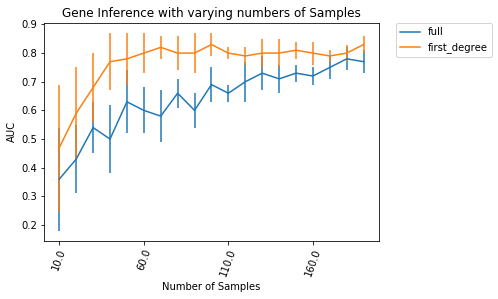

In [21]:
# results of adding Samples
plt.figure()

line1 = plt.errorbar(full_results.index, full_results['auc'], xerr=0, yerr=full_results['std'])
line2 = plt.errorbar(first_degree_results.index, first_degree_results['auc'], xerr=0, yerr=first_degree_results['std'])

width = 0.2
plt.xticks(list(full_results.iloc[::5, :].index), full_results.iloc[::5, :]['samples'], rotation=70)
plt.title("Gene Inference with varying numbers of Samples")
plt.ylabel("AUC")
plt.xlabel("Number of Samples")
plt.legend((line1[0], line2[0]), ('full', 'first_degree'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)

In [22]:
# Predict a gene from a growing number of Nodes
results = pd.DataFrame([])
gene = "RPL5"
num_samples = 100
max_genes = 100

for i in range(10, max_genes, 2):
    results = results.append(infer_gene(lr, tcgatissue.df.loc[:num_samples, sample_neighbors(g, "RPL5", i)], "RPL5", g)).reset_index(drop=True)
    results.loc[results.index[-1], 'nodes'] = i

gene_inference/infer_genes.py:19: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  first_degree_neighbors = temp_genes.loc[:, list(g.neighbors(gene_to_infer))].dropna(axis=1)


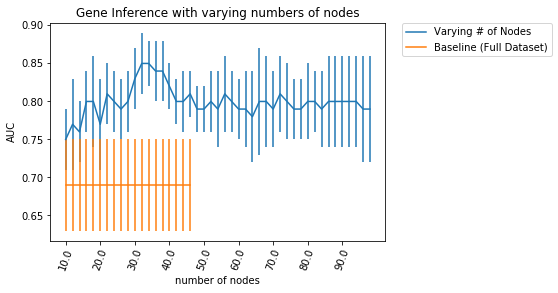

In [23]:
# results of adding Nodes
plt.figure()

#full_results.loc[full_results['samples'] == 100]

line1 = plt.errorbar(results.index, results['auc'], xerr=0, yerr=results['std'])
line2 = plt.errorbar(full_results.index, list(repeat(0.69, len(full_results))), xerr=0, yerr=list(repeat(0.06, len(full_results))))

width = 0.2
plt.xticks(list(results.iloc[::5, :].index), results.iloc[::5, :]['nodes'], rotation=70)
plt.title("Gene Inference with varying numbers of nodes")
plt.ylabel("AUC")
plt.xlabel("number of nodes")
plt.legend((line1[0], line2[0]), ('Varying # of Nodes', "Baseline (Full Dataset)"), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)

In [24]:
full_results

,auc,first_degree_auc,first_degree_diff,first_degree_std,gene_name,samples,second_degree_auc,second_degree_diff,second_degree_std,std
0,0.36,0.38,-0.02,0.18,RPL5,10.0,0.35,0.01,0.15,0.18
1,0.43,0.61,-0.18,0.11,RPL5,20.0,0.61,-0.18,0.05,0.12
2,0.54,0.63,-0.09,0.06,RPL5,30.0,0.62,-0.08,0.10,0.09
3,0.50,0.79,-0.29,0.09,RPL5,40.0,0.77,-0.27,0.10,0.12
4,0.63,0.77,-0.14,0.07,RPL5,50.0,0.79,-0.16,0.10,0.11
5,0.60,0.80,-0.20,0.07,RPL5,60.0,0.80,-0.20,0.07,0.08
6,0.58,0.84,-0.26,0.04,RPL5,70.0,0.77,-0.19,0.07,0.09
7,0.66,0.81,-0.15,0.05,RPL5,80.0,0.83,-0.17,0.05,0.05
8,0.60,0.83,-0.23,0.07,RPL5,90.0,0.76,-0.16,0.04,0.06
9,0.69,0.83,-0.14,0.03,RPL5,100.0,0.81,-0.12,0.05,0.06


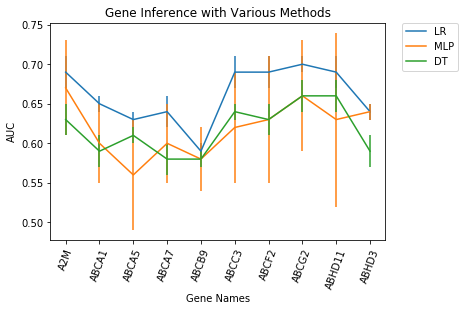

In [25]:
# AUC
plt.figure()

line1 = plt.errorbar(lr_df.index, lr_df['auc'], xerr=0, yerr=lr_df['std'])
line2 = plt.errorbar(mlp_df.index, mlp_df['auc'], xerr=0, yerr=mlp_df['std'])
line3 = plt.errorbar(dt_df.index, dt_df['auc'], xerr=0, yerr=dt_df['std'])

width = 0.2
plt.xticks(lr_df.index, lr_df['gene_name'], rotation=70)
plt.title("Gene Inference with Various Methods")
plt.ylabel("AUC")
plt.xlabel("Gene Names")
plt.legend((line1[0], line2[0], line3[0]), ('LR', 'MLP', 'DT'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)

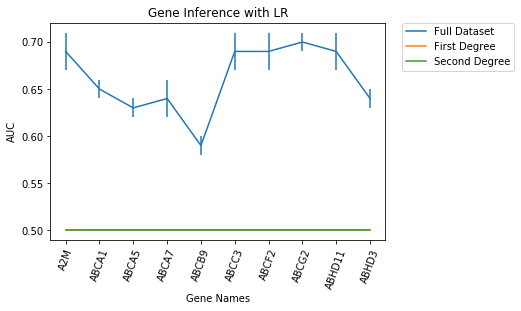

In [26]:
# LR 
plt.figure()
line1 = plt.errorbar(lr_df.index, lr_df['auc'], xerr=0, yerr=lr_df['std'])
line2 = plt.errorbar(lr_df.index, lr_df['first_degree_auc'], xerr=0, yerr=lr_df['first_degree_std'])
line3 = plt.errorbar(lr_df.index, lr_df['second_degree_auc'], xerr=0, yerr=lr_df['second_degree_std'])

width = 0.2
plt.xticks(lr_df.index, lr_df['gene_name'], rotation=70)
plt.title("Gene Inference with LR")
plt.ylabel("AUC")
plt.xlabel("Gene Names")
plt.legend((line1[0], line2[0], line3[0]), ('Full Dataset', 'First Degree', 'Second Degree'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)

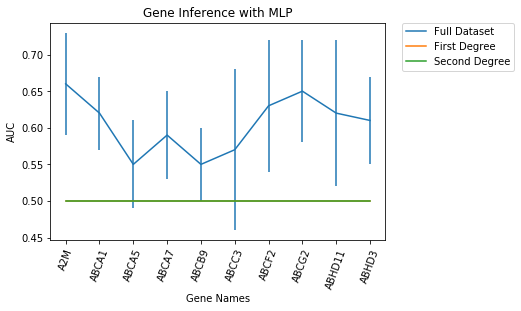

In [24]:
#mlp
plt.figure()
line1 = plt.errorbar(mlp_df.index, mlp_df['auc'], xerr=0, yerr=mlp_df['std'])
line2 = plt.errorbar(mlp_df.index, mlp_df['first_degree_auc'], xerr=0, yerr=mlp_df['first_degree_std'])
line3 = plt.errorbar(mlp_df.index, mlp_df['second_degree_auc'], xerr=0, yerr=mlp_df['second_degree_std'])

width = 0.2
plt.xticks(mlp_df.index, mlp_df['gene_name'], rotation=70)
plt.title("Gene Inference with MLP")
plt.ylabel("AUC")
plt.xlabel("Gene Names")
plt.legend((line1[0], line2[0], line3[0]), ('Full Dataset', 'First Degree', 'Second Degree'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)

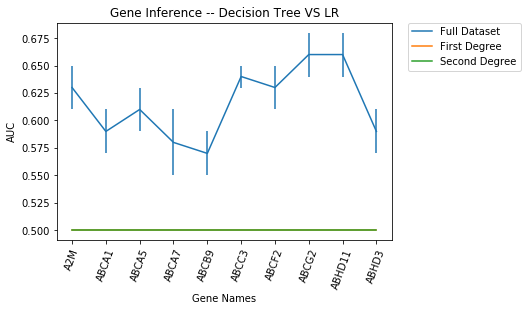

In [26]:
# Decision Tree
plt.figure()

line1 = plt.errorbar(dt_df.index, dt_df['auc'], xerr=0, yerr=dt_df['std'])
line2 = plt.errorbar(dt_df.index, dt_df['first_degree_auc'], xerr=0, yerr=dt_df['first_degree_std'])
line3 = plt.errorbar(dt_df.index, dt_df['second_degree_auc'], xerr=0, yerr=dt_df['second_degree_std'])

width = 0.2
plt.xticks(dt_df.index, dt_df['gene_name'], rotation=70)
plt.title("Gene Inference -- Decision Tree VS LR")
plt.ylabel("AUC")
plt.xlabel("Gene Names")

# Legend
plt.legend((line1[0], line2[0], line3[0]), ('Full Dataset', 'First Degree', 'Second Degree'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)


In [ ]:
# Graphical Character example

In [455]:
# 1st degree
first_degree_neighbors = g.neighbors("RPL5")
first_degree_neighbor_subgraph = g.subgraph(first_degree_neighbors)

'num nodes:29'

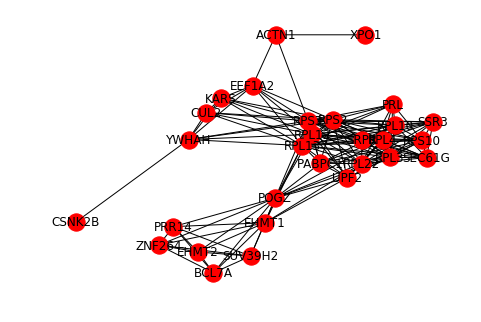

In [456]:
pos = nx.spring_layout(first_degree_neighbor_subgraph, k=1.45,iterations=100)
nx.draw(first_degree_neighbor_subgraph, pos=pos, with_labels=True)
"num nodes:" + str(len([x for x  in g.neighbors("RPL5")]))

In [299]:
# 2nd degree
second_degree_neighborhood = []
for n in g.neighbors("RPL5"):
    second_degree_neighborhood.extend(g.neighbors(n))
second_degree_subgraph = g.subgraph(second_degree_neighborhood)

'num nodes:1147'

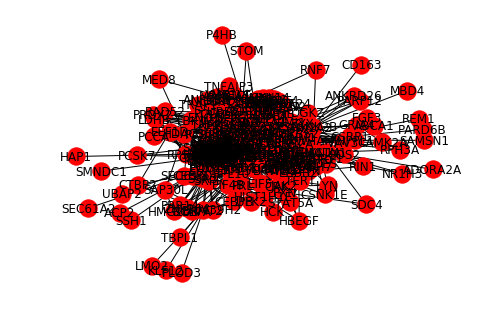

In [300]:
pos = nx.spring_layout(second_degree_subgraph, k=.25,iterations=100)
nx.draw(second_degree_subgraph, pos=pos, with_labels=True)
"num nodes:" + str(len(second_degree_neighborhood))